In [1]:
import sys
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
import pm4py
import math

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### cleaning 

In [2]:
def read_and_clean_dataset(file_path):
    # read dataset
    data_raw = pm4py.read_xes(file_path)
        
    # Let's only consider the complete lifecycle:transition, this is because the value "complete" meaning
    # the ongoing single event task is finished instead of being suspended or withdrawal, increasing the possibility to
    # get more complete traces for our prediction
    data_raw = data_raw[data_raw['lifecycle:transition'] == 'complete']
    log = pm4py.convert_to_event_log(data_raw)
        
    # Only keep two most frequent traces, we believe these are the most complete traces
    filtered_log = pm4py.filter_end_activities(log, ['A_Pending','O_Cancelled'])
        
    df = pm4py.convert_to_dataframe(filtered_log)
    agg_dict = {"time:timestamp" :['min', 'max']}
    duration_df = pd.DataFrame(df.groupby("case:concept:name").agg(agg_dict)).reset_index()
    duration_df["trace_duration_days"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds() / (24 * 60 * 60)
    duration_df['trace_duration_days'] = duration_df['trace_duration_days'].apply(lambda x: math.ceil(x))
    duration_df["trace_duration_seconds"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds()
    duration_df.drop(columns=['time:timestamp'],inplace=True)
    duration_df = duration_df.droplevel(1, axis=1)

    df_with_duration = df.merge(duration_df, on='case:concept:name')
    #df_with_duration['sum_Time_sec'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.iloc[0]).dt.total_seconds()
    df_with_duration_remain = df_with_duration.copy()
    df_with_duration_remain['remaining_time'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.iloc[-1] - x).dt.total_seconds()
    #df_with_duration_remain['Complete_Timestamp'] = df_with_duration_remain.groupby('case:concept:name')['time:timestamp'].transform('last')
    #df_with_duration['duration'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds()
        
    return df_with_duration_remain
# Duration time, remaining_time cannot be used for testing, just for knowing data distribution

In [3]:
data = read_and_clean_dataset('/Users/syeniperea/Desktop/PROFESIONAL/TUE/prom-lite-1.4-all-platforms/RETO FILES/BPI Challenge 2017.xes')

/usr/local/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/var/folders/1k/g6jpvmcs1cxb7t87t60d7dy40000gn/T/ipykernel_53496/1470292893.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  duration_df.drop(columns=['time:timestamp'],inplace=True)


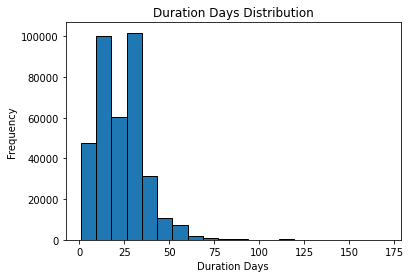

In [4]:
import matplotlib.pyplot as plt

# Assuming df_with_duration is your DataFrame containing the 'duration_days' column
# Make sure you have imported the pandas and matplotlib libraries

# Plotting the histogram
plt.hist(data['trace_duration_days'], bins=20, edgecolor='black')  # Adjust the number of bins according to your data
plt.title('Duration Days Distribution')
plt.xlabel('Duration Days')
plt.ylabel('Frequency')
plt.show()

In [5]:
quantile_25 = data['trace_duration_days'].quantile(0.25)
quantile_75 = data['trace_duration_days'].quantile(0.75)
data_iqr = data[(data['trace_duration_days'] >= quantile_25) & (data['trace_duration_days'] <= quantile_75)]

In [143]:
data_iqr['concept:name'].unique()


array(['A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted',
       'O_Create Offer', 'O_Created', 'O_Sent (mail and online)',
       'A_Complete', 'A_Validating', 'O_Returned', 'A_Incomplete',
       'O_Accepted', 'A_Pending', 'W_Complete application', 'O_Cancelled',
       'W_Handle leads', 'W_Validate application', 'A_Cancelled',
       'O_Sent (online only)', 'W_Call incomplete files',
       'W_Call after offers', 'W_Assess potential fraud'], dtype=object)

In [144]:
all_act=['concept:name_A_Create Application', 'concept:name_A_Submitted', 'concept:name_A_Concept', 'concept:name_A_Accepted',
       'concept:name_O_Create Offer', 'concept:name_O_Created', 'concept:name_O_Sent (mail and online)',
       'concept:name_A_Complete', 'concept:name_A_Validating', 'concept:name_O_Returned', 'concept:name_A_Incomplete',
       'concept:name_O_Accepted', 'concept:name_A_Pending', 'concept:name_W_Complete application', 'concept:name_O_Cancelled',
       'concept:name_W_Handle leads', 'concept:name_W_Validate application', 'concept:name_A_Cancelled',
       'concept:name_O_Sent (online only)', 'concept:name_W_Call incomplete files',
       'concept:name_W_Call after offers', 'concept:name_W_Assess potential fraud']

### Prediction

In [52]:
train_df, test_df = pm4py.split_train_test(data_iqr, train_percentage=0.75)
train_df['remaining_time_days'] = round(train_df['remaining_time'] / 86400,3) #add remaining time in days
test_df['remaining_time_days'] = round(test_df['remaining_time'] / 86400,3) #add remaining time in days

/var/folders/1k/g6jpvmcs1cxb7t87t60d7dy40000gn/T/ipykernel_53496/3641389979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['remaining_time_days'] = round(train_df['remaining_time'] / 86400,3)
/var/folders/1k/g6jpvmcs1cxb7t87t60d7dy40000gn/T/ipykernel_53496/3641389979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['remaining_time_days'] = round(test_df['remaining_time'] / 86400,3)


In [138]:

import pandas as pd

def AggregateTransformer(X, case_id_col, num_cols, cat_cols, all_activities):
    # Ensure concept:name is in cat_cols for dummy variable creation
    if 'concept:name' not in cat_cols:
        cat_cols.append('concept:name')

    # Transform numeric columns
    dt_numeric = pd.DataFrame()
    if len(num_cols) > 0:
        dt_numeric = X.groupby(case_id_col)[num_cols].agg(["mean", "max", "min", "sum", "std"])
        dt_numeric.columns = ['_'.join(col).strip() for col in dt_numeric.columns.values]

    # Transform categorical columns - creating dummy variables
    dt_cat = pd.get_dummies(X[cat_cols])
    dt_cat[case_id_col] = X[case_id_col]

    # Group by case_id_col and sum to get count of each activity per case
    dt_cat_grouped = dt_cat.groupby(case_id_col).sum()

    # Add missing activity columns with 0 values
    missing_activities = set(all_activities) - set(dt_cat_grouped.columns)
    for activity in missing_activities:
        dt_cat_grouped[activity] = 0

    # Concatenate numeric and categorical data
    dt_transformed = pd.concat([dt_cat_grouped, dt_numeric], axis=1)

    # Fill missing values with 0
    dt_transformed.fillna(0, inplace=True)
    
    return dt_transformed




In [145]:
case_id_col = 'case:concept:name'
y_col = 'remaining_time'
dynamic_cat_cols = ['concept:name']
static_cat_cols = ['case:LoanGoal','case:ApplicationType']
dynamic_num_cols = ['FirstWithdrawalAmount','NumberOfTerms',
                                 'OfferedAmount','MonthlyCost']
static_num_cols = ['case:RequestedAmount']

In [146]:
# Get prefixed with length 6,7,8,9,10
bucket_train = []
for len_prefix in [6,7,8,9,10]:
    bucket_train.append(pm4py.get_prefixes_from_log(train_df, length=len_prefix, case_id_key='case:concept:name'))

In [147]:
# Get prefixed with length 6,7,8,9,10
bucket_test = []
for len_prefix in [6,7,8,9,10]:
    bucket_test.append(pm4py.get_prefixes_from_log(test_df, length=len_prefix, case_id_key='case:concept:name'))

In [150]:
# encode training
encoded_bucket = []
for bucket in bucket_train:
    encoded_bucket.append(AggregateTransformer(bucket,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act))

In [148]:
# encode test
encoded_test = []
for bucket in bucket_test:
    encoded_test.append(AggregateTransformer(bucket,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols,all_activities=all_act))

In [149]:
encoded_test[0]

,concept:name_A_Accepted,concept:name_A_Cancelled,concept:name_A_Concept,concept:name_A_Create Application,concept:name_A_Submitted,concept:name_O_Cancelled,concept:name_O_Create Offer,concept:name_O_Created,concept:name_O_Sent (mail and online),concept:name_O_Sent (online only),...,OfferedAmount_mean,OfferedAmount_max,OfferedAmount_min,OfferedAmount_sum,OfferedAmount_std,MonthlyCost_mean,MonthlyCost_max,MonthlyCost_min,MonthlyCost_sum,MonthlyCost_std
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_1002626536,1,0,1,1,1,0,1,1,0,0,...,17500.0,17500.0,17500.0,17500.0,0.0,179.80,179.80,179.80,179.80,0.0
Application_1003445359,1,0,1,1,1,0,1,1,0,0,...,15000.0,15000.0,15000.0,15000.0,0.0,250.00,250.00,250.00,250.00,0.0
Application_1004618053,1,0,1,1,0,0,1,1,1,0,...,21000.0,21000.0,21000.0,21000.0,0.0,210.00,210.00,210.00,210.00,0.0
Application_1004718670,1,0,1,1,0,0,1,1,1,0,...,15000.0,15000.0,15000.0,15000.0,0.0,150.00,150.00,150.00,150.00,0.0
Application_1005878170,1,0,1,1,1,0,1,0,0,0,...,45000.0,45000.0,45000.0,45000.0,0.0,470.67,470.67,470.67,470.67,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Application_997711293,1,0,1,1,1,0,1,1,0,0,...,54000.0,54000.0,54000.0,54000.0,0.0,549.84,549.84,549.84,549.84,0.0
Application_998310056,1,0,1,1,0,0,1,1,1,0,...,6700.0,6700.0,6700.0,6700.0,0.0,142.86,142.86,142.86,142.86,0.0
Application_998666405,1,0,1,1,1,0,1,0,0,0,...,45200.0,45200.0,45200.0,45200.0,0.0,460.24,460.24,460.24,460.24,0.0


In [152]:
#make data frames
df0=pd.DataFrame(encoded_bucket[0])
dfy0=pd.DataFrame(bucket_train[0])

df_test0=pd.DataFrame(encoded_test[0])
dfy_test0= pd.DataFrame(bucket_test[0])


In [154]:
#function to get labels ready
def df4prediction(df_train, df_y , case_id_col):
 
    df_= df_y.groupby(case_id_col)['remaining_time'].last().reset_index()
    Y=df_['remaining_time']

    df_y_days= df_y.groupby(case_id_col)['remaining_time_days'].last().reset_index()
    Y_days=df_y_days['remaining_time_days']

    return df_train, Y, Y_days


### bucket 0

In [156]:
df_train0, Y0, Y_days0=df4prediction(df0,dfy0,case_id_col)


In [158]:
df_test0, Y0_test, Y_days0_test=df4prediction(df_test0,dfy_test0,case_id_col)


In [159]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [160]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(df_train0, Y0 ) #random forest seconds


RandomForestRegressor(random_state=42)

In [161]:
rf_model_days = RandomForestRegressor(random_state=42)
rf_model_days.fit(df_train0, Y_days0 )  #random forest days

RandomForestRegressor(random_state=42)

In [162]:
y_pred = rf_model.predict(df_test0)

# Calculate and print the errors
mse = mean_squared_error(Y0_test, y_pred)
mae = mean_absolute_error(Y0_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 469021075876.72986
Mean Absolute Error: 591615.3613548309


In [163]:
y_pred_days = rf_model_days.predict(df_test0)

# Calculate and print the errors
mse = mean_squared_error(Y_days0_test, y_pred_days)
mae = mean_absolute_error(Y_days0_test, y_pred_days)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 62.8695527786695
Mean Absolute Error: 6.850940887984516


In [164]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regressor = LinearRegression()

#linear regreession days
regressor.fit(df_train0, Y_days0)



LinearRegression()

In [165]:

y_pred = regressor.predict(df_test0)


# The mean squared error
print('Mean squared error:', mean_squared_error(Y_days0_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination:', r2_score(Y_days0_test, y_pred))

Mean squared error: 56.93124694151007
Coefficient of determination: 0.009316642758964377


### Bucket 1

In [169]:
#prepare training data
x_train1=encoded_bucket[1]
y_train1= bucket_train[1]
x_train1,y_train1,y_train_days1=df4prediction(x_train1,y_train1,case_id_col)




In [170]:
#prepare test data
x_test1=encoded_test[1]
y_test1= bucket_test[1]
x_test1,y_test1,y_test_days1=df4prediction(x_test1,y_test1,case_id_col)


In [175]:

#random forest days
rf1_model = RandomForestRegressor(random_state=42)
rf1_model.fit(x_train1, y_train_days1 )

y_pred = rf1_model.predict(x_test1)

# Calculate and print the errors
mse = mean_squared_error(y_test_days1, y_pred)
mae = mean_absolute_error(y_test_days1, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")



Mean Squared Error: 61.68201188788958
Mean Absolute Error: 6.777553795071848


In [177]:
#linear regression days
regressor1 = LinearRegression()

# Train the model using the training sets
regressor1.fit(x_train1, y_train_days1)

# Make predictions using the testing set
y_pred = regressor1.predict(x_test1)


# The mean squared error
print('Mean squared error:', mean_squared_error(y_test_days1, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination:', r2_score(y_test_days1, y_pred))


Mean squared error: 56.81109399830614
Coefficient of determination: 0.019816172756173756


### Bucket 2

In [189]:
#prepare training data
x_train2=encoded_bucket[2]
y_train2= bucket_train[2]
x_train2,y_train2,y_train_days2=df4prediction(x_train2,y_train2,case_id_col)

In [190]:
#prepare test data
x_test2=encoded_test[2]
y_test2= bucket_test[2]
x_test2,y_test2,y_test_days2=df4prediction(x_test2,y_test2,case_id_col)

In [191]:
#random forest days
rf2_model = RandomForestRegressor(random_state=42)
rf2_model.fit(x_train2, y_train_days2 )

y_pred = rf2_model.predict(x_test2)

# Calculate and print the errors
mse = mean_squared_error(y_test_days2, y_pred)
mae = mean_absolute_error(y_test_days2, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 59.78375861954808
Mean Absolute Error: 6.579225292977653


In [192]:
#linear regression days
regressor2 = LinearRegression()

# Train the model using the training sets
regressor2.fit(x_train2, y_train_days2)

# Make predictions using the testing set
y_pred = regressor2.predict(x_test2)


# The mean squared error
print('Mean squared error:', mean_squared_error(y_test_days2, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination:', r2_score(y_test_days2, y_pred))

Mean squared error: 54.762361815532245
Coefficient of determination: 0.23841692134368098


### Bucket 3

In [194]:
#prepare training data
x_train3=encoded_bucket[3]
y_train3= bucket_train[3]
x_train3,y_train3,y_train_days3=df4prediction(x_train3,y_train3,case_id_col)

In [195]:
#prepare test data
x_test3=encoded_test[3]
y_test3= bucket_test[3]
x_test3,y_test3,y_test_days3=df4prediction(x_test3,y_test3,case_id_col)

In [197]:
#random forest days
rf3_model = RandomForestRegressor(random_state=42)
rf3_model.fit(x_train3, y_train_days3 )

y_pred = rf3_model.predict(x_test3)

# Calculate and print the errors
mse = mean_squared_error(y_test_days3, y_pred)
mae = mean_absolute_error(y_test_days3, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 102.71298021595433
Mean Absolute Error: 7.955361128690022


In [198]:
#linear regression days
regressor3 = LinearRegression()

# Train the model using the training sets
regressor3.fit(x_train3, y_train_days3)

# Make predictions using the testing set
y_pred = regressor3.predict(x_test3)


# The mean squared error
print('Mean squared error:', mean_squared_error(y_test_days3, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination:', r2_score(y_test_days3, y_pred))

Mean squared error: 154.17944718463326
Coefficient of determination: -0.3309309257507145


### Bucket 4

In [199]:
#prepare training data
x_train4=encoded_bucket[4]
y_train4= bucket_train[4]
x_train4,y_train4,y_train_days4=df4prediction(x_train4,y_train4,case_id_col)

In [200]:
#prepare test data
x_test4=encoded_test[4]
y_test4= bucket_test[4]
x_test4,y_test4,y_test_days4=df4prediction(x_test4,y_test4,case_id_col)

In [201]:
#random forest days
rf4_model = RandomForestRegressor(random_state=42)
rf4_model.fit(x_train4, y_train_days4 )

y_pred = rf4_model.predict(x_test4)

# Calculate and print the errors
mse = mean_squared_error(y_test_days4, y_pred)
mae = mean_absolute_error(y_test_days4, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 27.02373699569119
Mean Absolute Error: 3.495141048137421


In [202]:
#linear regression days
regressor4 = LinearRegression()

# Train the model using the training sets
regressor4.fit(x_train4, y_train_days4)

# Make predictions using the testing set
y_pred = regressor4.predict(x_test4)


# The mean squared error
print('Mean squared error:', mean_squared_error(y_test_days4, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination:', r2_score(y_test_days4, y_pred))

Mean squared error: 25.644802734595228
Coefficient of determination: 0.6842944139699103
